In [1]:
# default_exp models

# module name here

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#export
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F

In [4]:
torch.cuda.is_available()

True

# H 

### Encoder

In [5]:
#export
class Encoder_h(nn.Module):
    def __init__(self, Y_dim, H_dim, hidden_dim = 16):
        super().__init__()
        self.make_encoder(Y_dim, H_dim, hidden_dim)
  
    def make_encoder(self, Y_dim, H_dim, hidden_dim):
        self.net = nn.Sequential(nn.Linear(Y_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, hidden_dim), nn.Tanh())
        self.mu = nn.Linear(hidden_dim, H_dim)
        self.std = nn.Sequential(nn.Linear(hidden_dim, H_dim), nn.Softplus())
  
    def forward(self, y):
        hidden_state = self.net(y)
        mu, std = self.mu(hidden_state), self.std(hidden_state)
        return dist.Normal(mu, std)

### Decoder

In [6]:
#export
class Decoder_h(nn.Module):
    def __init__(self, B, H_dim):
        super().__init__()
        self.B = B
        self.H_dim = H_dim
        self.make_parameters()

    def make_parameters(self):
        self.mu = nn.Linear(self.H_dim, self.B, bias=False) #Just the matrix
        self.sigma = nn.Linear(self.H_dim, self.B, bias=False) #Just the matrix
        torch.nn.init.uniform_(self.sigma.weight, a=1.0, b=2.0)
#         self.mu = nn.Parameter(torch.randn(self.B, self.H_dim))
#         sigma = torch.rand(self.B, self.H_dim).view(self.B, self.H_dim) * torch.randint(1,10, (1,), dtype=torch.float32)
#         self.sigma = nn.Parameter(sigma)

    def _log_likelihood(self, h):
        """
        h: shape=(BS,N,H_dim)
        """
        BS, S, H_dim = h.shape
        return dist.Normal(self.mu.weight.view(1,1,self.B,H_dim), self.sigma.weight.view(1,1,self.B,self.H_dim)).log_prob(h.view(BS, S, 1, H_dim))

    def forward(self, z):
        """
        z: shape = (BS,N) or (BS,) or (1,)
        """
        # print(z_n)
        h_dist = dist.Normal(self.mu.weight[z], self.sigma.weight[z])
        return h_dist.rsample()

# X

### Encoder

In [7]:
#export
class Encoder_x(nn.Module):
    def __init__(self, I_dim, H_dim, X_dim, hidden_size=16, inducing_point_stride=None):
        super().__init__()
        self.inducing_point_stride = inducing_point_stride
        self.hidden_size = hidden_size
        self.make_network(I_dim, H_dim, X_dim, hidden_size)

    def make_network(self, I_dim, H_dim, X_dim, hidden_size):
        self.bilstm = nn.LSTM(input_size=I_dim+H_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        # self.densenet = nn.Sequential(nn.Linear(2*hidden_size, X_dim), nn.ReLU())
        self.mu = nn.Linear(2*hidden_size, X_dim)
        self.sigma = nn.Sequential(nn.Linear(2*hidden_size, X_dim), nn.Softplus())
  
    def forward(self, i_seq, h_seq):
        """
        i_seq: shape = (BS, N)
        h_seq: shape = (BS, N, H_dim)
        """
        BS, T = i_seq.shape
        assert(len(i_seq.shape)==2)
        lstm_input = torch.cat([i_seq.view(*i_seq.shape, 1), h_seq], dim=-1)
        hidden, _ = self.bilstm(lstm_input) #shape(hidden) = (BS, N, 2*hidden_size)
    
        if self.inducing_point_stride is not None:
            mu, sigma = self.mu(hidden[:, ::self.inducing_point_stride]), self.sigma(hidden[:, ::self.inducing_point_stride])
        else:
            mu, sigma = self.mu(hidden), self.sigma(hidden)
        return dist.Normal(mu, sigma)

# Z

In [8]:
#export
class Model_z(nn.Module):
    def __init__(self, B, debug=False):
        super().__init__()
        self.B = B
        self.make_parameters(debug=debug)
    
    def make_parameters(self, X_dim = 1, debug=False):
        self.Wx = nn.Linear(X_dim, self.B, bias=False)
        # not a good idea: the norm is very high this way
#         if debug:
#             with torch.no_grad():
#                 self.Wx.weight.copy_(Params.Wx.view(*self.Wx.weight.shape))
        self.P = nn.Parameter((torch.rand((self.B,self.B)) + torch.eye(self.B,self.B)))
        self.logpi = nn.Parameter(torch.rand((1,self.B)))
    
    def transform_x(self, x):
        """
        x: shape=(BS,N)
        """
        x = x.view(*x.shape, 1) #shape=(BS,N,1)
        return self.Wx(x)
    
    def forward(self, x, z_prev):
        """
        x: shape=(BS,N)
        z_prev: shape=(BS,N)
        """
        logits = self.transform_x(x_n) + self.P[z_prev] #shape=(BS,N,B)
        dist_z = dist.Categorical(logits=logits)
        return dist_z.sample()

# I

### Decoder

In [9]:
#export
class Decoder_i(nn.Module):
    def __init__(self, X_dim, B):
        super().__init__()
        self.B = B
        self.make_parameters(X_dim, B)

    def make_parameters(self, X_dim, B):
        # self.beta_a = nn.Parameter(torch.randn(X_dim + B + 1))
        # self.beta_b = nn.Parameter(torch.randn(X_dim + B + 1))
        self.glm = nn.Linear(X_dim + B, 2)

    def _make_one_hot(self, z_n):
        return F.one_hot(z_n, num_classes=self.B).float()

    def _log_likelihood(self, i_n, x_n, z_n):
        """
        i_n: shape=(BS,N)
        x_n: shape=(BS,N)
        z_n: shape=(BS,N)
        """
        # BS, S = i_n.shape
        dist_i = self._forward(x_n, z_n)
        return dist_i.log_prob(i_n)
    
    def _forward(self, x_n, z_n):
        """
        x_n - shape=(BS,N)
        z_n - shape=(BS,N)
        """
        x_n = x_n.view(*x_n.shape, 1) #shape = (BS,N,1)
        z_n_one_hot = self._make_one_hot(z_n) #shape= (BS,N,B)
        glm_input = torch.cat([x_n, z_n_one_hot], dim=-1)
        gamma_params = self.glm(glm_input).mul(-1).exp() #shape= (BS,N,2)
        num_dims = len(gamma_params.shape)
        # from docs: tensor.select(0, index) is equivalent to tensor[index] and tensor.select(2, index) is equivalent to tensor[:,:,index].
        a, b = gamma_params.select(num_dims-1, 0), gamma_params.select(num_dims-1, 1)
        # gamma_params[*prev_shape,0], gamma_params[*prev_shape,1]
        dist_i = dist.Gamma(a, b)
        return dist_i

    def forward(self, x_n, z_n):
        """
        x_n - shape=(BS,N)
        z_n - shape=(BS,N)
        """
        # print(x_n.shape, z_n.shape)


        # old code
        # glm_input = torch.cat([torch.ones(*x_n.shape, 1), x_n, z_n_one_hot], dim=-1)
        # a = torch.dot(self.beta_a, glm_input)
        # b = torch.dot(self.beta_b, glm_input)

        # new way - using matrix multiplication
        dist_i = self._forward(x_n, z_n)
        return dist_i.rsample()

# Y

In [10]:
#export
class Decoder_y(nn.Module):
    def __init__(self, H_dim, Y_dim, hidden_dim=32):
        super().__init__()
        self.make_parameters(H_dim, Y_dim, hidden_dim)
    
    def make_parameters(self, H_dim, Y_dim, hidden_dim):
        self.base_net = nn.Sequential(nn.Linear(H_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, hidden_dim), nn.Tanh())
        self.mu = nn.Linear(hidden_dim, Y_dim)
        self.std = nn.Sequential(nn.Linear(hidden_dim, Y_dim), nn.Softplus())
        
    def _log_likelihood(self, H, Y):
        """
        H: shape=(BS,N,H_dim)
        Y: shape=(BS,N,Y_dim)
        """
        BS, S, Y_dim = Y.shape
        dist_Y = self.forward(H)
        return dist_Y.log_prob(Y)
    
    def forward(self, H):
        """
        H: shape=(BS,N,H_dim)
        """
        hidden = self.base_net(H)
        mu, std = self.mu(hidden), self.std(hidden)
        dist_Y = dist.Normal(mu, std)
        return dist_Y

# Message passing routines

### $l_n$

In [11]:
#export
def l_n_vectorized(I, X, H, B, model_i, model_h, device):
    """
    I: shape=(BS,N)
    X: shape=(BS,N)
    H: shape=(BS,N,H_dim)
    device: 'cuda'/'cpu'

    Output:
    out: shape=(BS,N,B,1)
    """
    # sort of a workaround
    Z = torch.arange(B).view(*torch.ones(len(X.shape), dtype=int), B).expand(*X.shape, -1).to(device)
    X = X.view(*X.shape, 1).expand(*X.shape, B)
    I = I.view(*I.shape, 1).expand(*I.shape, B)
    
    assert X.shape == I.shape == Z.shape
    
    ll_i = model_i._log_likelihood(I, X, Z) #shape = (BS,N,B)
    ll_h = model_h._log_likelihood(H) #shape=(BS,N,B,H_dim)
    # print(ll_i.shape, ll_h.shape)
    
    out = (ll_i + ll_h.sum(-1)).unsqueeze(-1) #shape for each = (BS,N,B)
    return out #shape for each = (BS,N,B,1)

In [12]:
#export
def l_n_vectorized_paper(I, Y, X, H, B, model_i, model_h, model_y, device):
    """
    I: shape=(BS,N)
    Y: shape=(BS,N)
    X: shape=(BS,N)
    H: shape=(BS,N,H_dim)
    device: 'cuda'/'cpu'

    Output:
    out: shape=(BS,N,B,1)
    """
    # sort of a workaround
    Z = torch.arange(B).view(*torch.ones(len(X.shape), dtype=int), B).expand(*X.shape, -1).to(device)
    X = X.view(*X.shape, 1).expand(*X.shape, B)
    I = I.view(*I.shape, 1).expand(*I.shape, B)
    
    assert X.shape == I.shape == Z.shape
    
    ll_i = model_i._log_likelihood(I, X, Z) #shape = (BS,N,B)
    ll_h = model_h._log_likelihood(H) #shape=(BS,N,B,H_dim)
    ll_y = model_y._log_likelihood(H, Y) #shape(BS,N,Y_dim)
    
    # print(ll_i.shape, ll_h.shape)
    
    out = (ll_i + ll_h.sum(-1) + ll_y.sum(-1).unsqueeze(-1)).unsqueeze(-1) #shape for each = (BS,N,B)
    return out #shape for each = (BS,N,B,1)

### $\psi_n$

In [13]:
#export
def psi_n_vectorized(X, model_z):
    """
    X: shape=(BS,N)
    """
    init_shape = X.shape
    X_mod = model_z.transform_x(X) #shape = (BS,N,B)
    X_mod = X_mod.unsqueeze(-2) #shape = (BS,N,1,B) - make 'row vector'

    unnorm_logits = model_z.P.view(1,1,*model_z.P.shape) + X_mod #shape = (1,1,B,B) + (BS,N,1,B) = (BS,N,B,B)
    normalizer = torch.logsumexp(unnorm_logits, dim=-1, keepdim=True) #shape = (BS,N,B,1)
    return (unnorm_logits - normalizer) #shape=(BS,N,B,B)

### $m_n$

In [14]:
#export
def compute_message(psi_matrix, l_vector, prev_message_vector):
    """
    psi_matrix: shape=(..., B,B)
    l_vector: shape=(..., B,1)
    prev_message_vector: shape=(..., B,1)

    Output: 
    next_message_vector: shape=(..., B,1)
    """
    raw_messages = psi_matrix + l_vector + prev_message_vector #shape=(..., B, B)
    next_message_vector = torch.logsumexp(raw_messages, dim=-2, keepdim=True) #shape=(..., 1, B) - 'row vector'
    next_message_vector = next_message_vector.transpose(-1,-2)

    #Alternate way of doing above two steps in one
    # _next_message_vector = torch.logsumexp(raw_messages, dim=-2, keepdim=False).unsqueeze(-1)
    # print((next_message_vector - _next_message_vector).sum())

    return next_message_vector

In [15]:
#export
def compute_message_paper(psi_matrix, l_vector, prev_message_vector):
    """
    psi_matrix: shape=(..., B,B)
    l_vector: shape=(..., B,1)
    prev_message_vector: shape=(..., B,1)

    Output: 
    next_message_vector: shape=(..., B,1)
    """
    raw_messages = psi_matrix + l_vector + prev_message_vector #shape=(..., B, B)
    next_message_vector = torch.logsumexp(raw_messages, dim=-2, keepdim=True) #shape=(..., 1, B) - 'row vector'
    next_message_vector = next_message_vector.transpose(-1,-2)

    #Alternate way of doing above two steps in one
    # _next_message_vector = torch.logsumexp(raw_messages, dim=-2, keepdim=False).unsqueeze(-1)
    # print((next_message_vector - _next_message_vector).sum())

    return next_message_vector

In [16]:
#export
def marginalize_z(I,Y,H,X, model_z, model_i, model_h):
    """
    I: shape=(BS,N)
    Y: shape=(BS,N,Y_dim)
    H: shape=(BS,N,H_dim)
    X: shape=(BS,N)
    
    output:
    normalized_factor: shape=(BS,N,1)
    """
    device = I.device
    N, S = X.shape
    B = model_z.B
    psi_matrix = psi_n_vectorized(X, model_z) #shape = (S,N,B,B)
    psi_matrix[:,0] *= 0 
  
    l = l_n_vectorized(I,X,H, B, model_i, model_h, device) #shape = (S,N,B,1)
    m = torch.zeros(N,S,B,1).to(device)

    m[:,0] += F.log_softmax(model_z.logpi, dim=-1).view(1,B,1) #better way of doing log(pi) - lse(log(pi))? = log(softmax( pi_unnorm ))
    for s in range(1,S):
        m[:,s] = compute_message(psi_matrix[:,s], l[:,s-1], m[:,s-1])
  
    normalized_factor = torch.logsumexp(m, dim=-2)
    return normalized_factor

In [17]:
#export
def marginalize_z_paper(I,Y,H,X, model_z, model_i, model_h, model_y):
    """
    I: shape=(BS,N)
    Y: shape=(BS,N,Y_dim)
    H: shape=(BS,N,H_dim)
    X: shape=(BS,N)
    
    output:
    normalized_factor: shape=(BS,N,1)
    """
    device = I.device
    N, S = X.shape
    B = model_z.B
    psi_matrix = psi_n_vectorized(X, model_z) #shape = (S,N,B,B)
    psi_matrix[:,0] *= 0 
  
    l = l_n_vectorized_paper(I,Y,X,H, B, model_i, model_h, model_y, device) #shape = (S,N,B,1)
    m = torch.zeros(N,S,B,1).to(device)

    m[:,0] += F.log_softmax(model_z.logpi, dim=-1).view(1,B,1) #better way of doing log(pi) - lse(log(pi))? = log(softmax( pi_unnorm ))
    for s in range(1,S):
        m[:,s] = compute_message(psi_matrix[:,s], l[:,s-1], m[:,s-1])
  
    normalized_factor = torch.logsumexp(m, dim=-2)
    return normalized_factor

In [20]:
from pp_lvm.simulations import TrueParameters, simulate_data
Params = TrueParameters(S=10, N=11, B=3, H_dim=2, Y_dim=2)
I,Y,T,X,Z,H = simulate_data(Params)
device='cuda'
model_z = Model_z(Params.B).to(device)
model_i = Decoder_i(1, Params.B).to(device)
model_h = Decoder_h(Params.B, Params.H_dim).to(device)
model_y = Decoder_y(Params.H_dim, Params.Y_dim).to(device)

with torch.no_grad():
    print(marginalize_z_paper(I,Y,H,X, model_z, model_i, model_h, model_y).shape)

torch.Size([10, 11, 1])


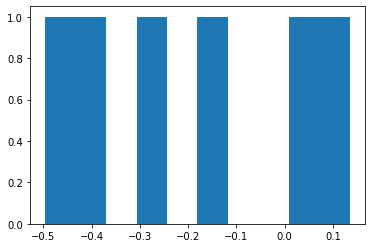

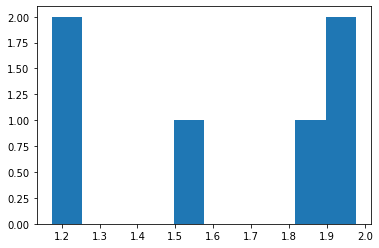

In [26]:
plt.hist(model_h.mu.weight.flatten().cpu().data); plt.show();
plt.hist(model_h.sigma.weight.flatten().cpu().data);

In [19]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_simulations.ipynb.
Converted 02_models.ipynb.
Converted 03_GP.ipynb.
Converted index.ipynb.
